
Ratings disponíveis: ['Aaa', 'Aa', 'A', 'Baa', 'Ba', 'B', 'Caa-C']

O problema especifica um horizonte de 3 a 5 anos.
Anos com dados exatos disponíveis: [0, 1, 2, 3, 4, 5, 7, 10, 15, 20]

--- 1. Análise Histórica (Real-World) para Rating: Aaa ---

Ano   | Prob. Acum. Q(t)   | Prob. Sobrev. V(t) | Prob. Incond. (no ano) | Prob. Cond. (no ano)     
-----------------------------------------------------------------------------------------------
1     | 0.0000%            | 100.0000%          | 0.0000%                | 0.0000%                  
      | (Hazard Rate Média até ano 1: -0.0000% anualizada)
2     | 0.0130%            | 99.9870%           | 0.0130%                | 0.0130%                  
      | (Hazard Rate Média até ano 2: 0.0065% anualizada)
3     | 0.0130%            | 99.9870%           | 0.0000%                | 0.0000%                  
      | (Hazard Rate Média até ano 3: 0.0043% anualizada)
4     | 0.0370%            | 99.9630%           | 0.0240%                | 0

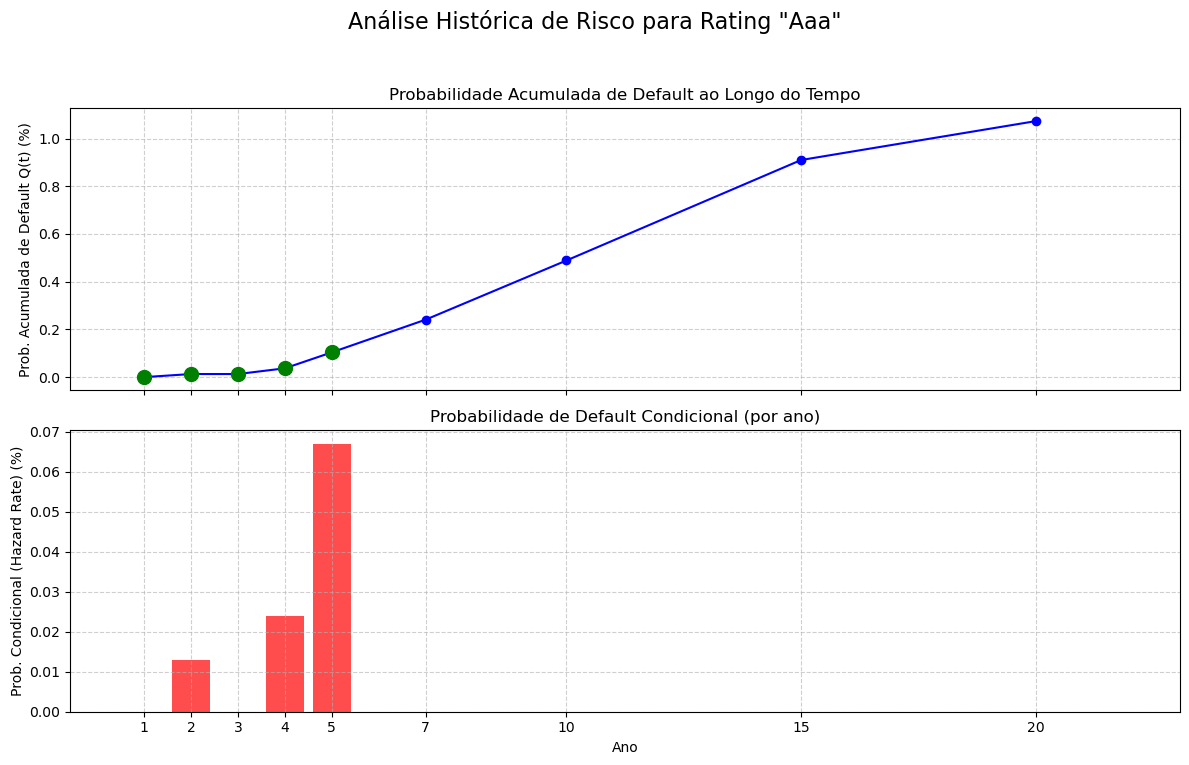


--- 2. Análise de Mercado (Risk-Neutral) ---
Esta análise (Seção 23.4) estima a prob. de default implícita no preço do título.

  6. Hazard Rate Média (Risk-Neutral) Estimada: 3.3333% (Fórmula 23.2)
     Compare este valor com a 'Hazard Rate Média' histórica (item 1).
     Se (Risk-Neutral) > (Histórica), o mercado está precificando um risco maior (prêmio de risco).

--- 3. Análise de Risco de Portfólio (Credit VaR) ---
Esta análise (Seção 23.10) estima a taxa de default 'pior caso' para um portfólio.

  7. Taxa de Default 'Pior Caso' (Credit VaR) em 5 anos, com 95.0% de confiança (Fórmula 23.13):
     Taxa de Default: 0.4403%
     (Compare com a prob. acumulada esperada Q(5) de 0.1040%)

Gerando gráfico de comparação do VaR...
Exibindo gráfico VaR... Feche a janela do gráfico para continuar.


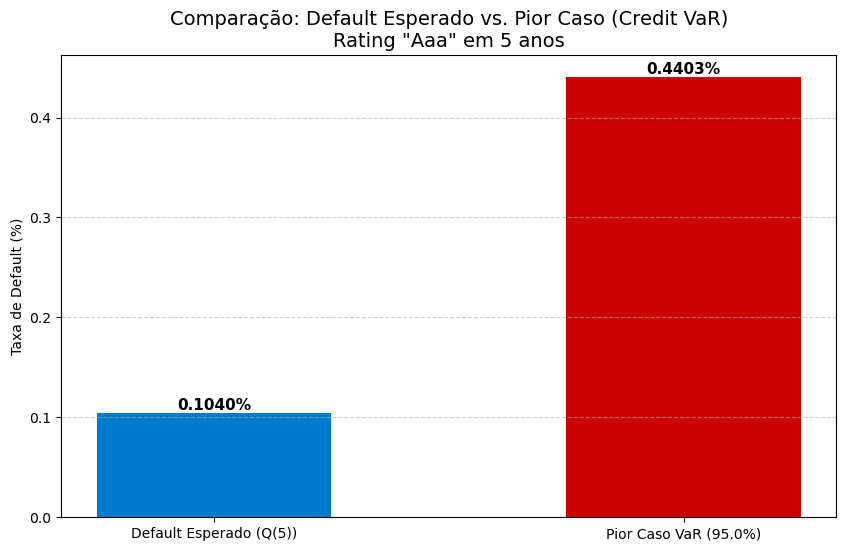


--- Análise Concluída ---


: 

In [ ]:
import math
from scipy.stats import norm

# Novas importações para gráficos, com verificação
try:
    import matplotlib.pyplot as plt
    import numpy as np
    MATPLOTLIB_AVAILABLE = True
except ImportError:
    print("\nAviso: 'matplotlib' e 'numpy' não estão instalados.")
    print("Os gráficos não serão gerados.")
    print("Para instalar, use: pip install matplotlib numpy")
    MATPLOTLIB_AVAILABLE = False

# --- Dados do Problema 5 ---
# Tabela: "Average Cumulative Default Rates (%), 1970-2013"
# Os valores foram convertidos de porcentagem (ex: 0,013%) para decimal (ex: 0.00013)
HISTORICAL_DATA_RAW = {
    "Time": [1, 2, 3, 4, 5, 7, 10, 15, 20],
    "Aaa": [0.00000, 0.00013, 0.00013, 0.00037, 0.00104, 0.00241, 0.00489, 0.00910, 0.01073],
    "Aa": [0.00022, 0.00068, 0.00136, 0.00260, 0.00410, 0.00682, 0.01017, 0.01871, 0.03167],
    "A": [0.00062, 0.00119, 0.00434, 0.00679, 0.00958, 0.01615, 0.02759, 0.04583, 0.07044],
    "Baa": [0.00174, 0.00504, 0.00906, 0.01373, 0.01862, 0.02872, 0.04623, 0.08306, 0.11969],
    "Ba": [0.01110, 0.03071, 0.05371, 0.07839, 0.10065, 0.13911, 0.19323, 0.28500, 0.35410],
    "B": [0.03904, 0.09274, 0.14723, 0.19509, 0.23869, 0.31774, 0.40560, 0.50275, 0.55892],
    "Caa-C": [0.15894, 0.27003, 0.35800, 0.42796, 0.48828, 0.56878, 0.66212, 0.73152, 0.74946]
}

def _processar_dados(raw_data):
    """Transforma os dados brutos em um formato de fácil consulta."""
    processed_data = {}
    ratings = list(raw_data.keys())
    ratings.remove("Time")
    years = raw_data["Time"]
    
    for rating in ratings:
        processed_data[rating] = {}
        for i, year in enumerate(years):
            processed_data[rating][year] = raw_data["Time"][i]
            processed_data[rating][year] = raw_data[rating][i]
        
        # Adiciona o ano 0 com 0% de default para facilitar cálculos marginais
        processed_data[rating][0] = 0.0
    return processed_data

# Dados prontos para a calculadora
CALCULATOR_DATA = _processar_dados(HISTORICAL_DATA_RAW)


class CalculadoraRiscoCredito:
    def __init__(self, data):
        self.data = data
        self.ratings = list(data.keys())
        self.anos_disponiveis = sorted(list(data["Aaa"].keys()))

    def _get_q(self, rating, year, silent=False):
        """
        Função auxiliar para obter a probabilidade de default acumulada Q(t).
        Retorna o valor Q(t) para o ano 'year'.
        Se 'silent=True', não imprime erros se o ano não for encontrado.
        """
        if rating not in self.data:
            if not silent: # Adicionado 'not silent'
                print(f"Erro: Rating '{rating}' não encontrado.")
            return None
        if year not in self.data[rating]:
            if not silent: # Adicionado 'not silent'
                print(f"Erro: Ano '{year}' não disponível nos dados. Anos disponíveis: {self.anos_disponiveis}")
            return None
        
        return self.data[rating][year]

    def get_prob_default_acumulada(self, rating, year):
        """
        1. Probabilidade de Default Acumulada Q(t)
        Retorna a prob. de default acumulada até o final do ano 'year'.
        """
        # Chama _get_q normalmente (com silent=False por padrão)
        return self._get_q(rating, year)

    def get_prob_sobrevivencia(self, rating, year):
        """
        2. Probabilidade de Sobrevivência V(t)
        Retorna a prob. de NÃO dar default até o final do ano 'year'.
        V(t) = 1 - Q(t)
        """
        # Chama _get_q normalmente (com silent=False por padrão)
        q_t = self._get_q(rating, year)
        if q_t is None:
            return None
        return 1.0 - q_t

    def get_prob_default_incondicional(self, rating, year):
        """
        3. Probabilidade de Default Incondicional (Marginal) para o ano 'year'
        Retorna a prob. de default *durante* o ano 'year', vista do tempo 0.
        P(Default no ano t) = Q(t) - Q(t-1)
        """
        q_t = self._get_q(rating, year)
        # Chama _get_q para (year - 1) silenciosamente
        q_t_menos_1 = self._get_q(rating, year - 1, silent=True) 
        
        if q_t is None or q_t_menos_1 is None:
            # Não imprime erro, chamador (tabela/gráfico) vai tratar o None
            return None
            
        return q_t - q_t_menos_1

    def get_prob_default_condicional(self, rating, year):
        """
        4. Probabilidade de Default Condicional (Hazard Rate) para o ano 'year'
        Prob. de default *durante* o ano 'year', *dado que* sobreviveu até 't-1'.
        P(Default no ano t | Sobreviveu até t-1) = [Q(t) - Q(t-1)] / [1 - Q(t-1)]
        """
        q_t = self._get_q(rating, year)
        # Chama _get_q para (year - 1) silenciosamente
        q_t_menos_1 = self._get_q(rating, year - 1, silent=True) 
        
        if q_t is None or q_t_menos_1 is None:
            # Não imprime erro, chamador (tabela/gráfico) vai tratar o None
            return None

        prob_sobrevivencia_t_menos_1 = 1.0 - q_t_menos_1
        if prob_sobrevivencia_t_menos_1 == 0:
            return None  # Evita divisão por zero

        prob_default_incondicional = q_t - q_t_menos_1
        return prob_default_incondicional / prob_sobrevivencia_t_menos_1

    def get_hazard_rate_media(self, rating, year):
        """
        5. Taxa de Risco (Hazard Rate) Média Anualizada (lambda)
        Calcula a taxa de risco média constante 'lambda' que resultaria
        na prob. de default acumulada Q(t) observada.
        Baseado na Fórmula 23.1: Q(t) = 1 - e^(-lambda * t)  =>  lambda = -ln(1 - Q(t)) / t
        """
        if year == 0:
            return 0.0
            
        q_t = self._get_q(rating, year)
        if q_t is None:
            return None
        
        if q_t == 1.0:
            return float('inf') # Default é certo

        prob_sobrevivencia = 1.0 - q_t
        # Adicionado tratamento para prob_sobrevivencia <= 0 (embora 1.0 já seja tratado)
        if prob_sobrevivencia <= 0:
            return float('inf')
            
        return -math.log(prob_sobrevivencia) / year

    def estimar_hazard_rate_risk_neutral(self, spread, recovery_rate):
        """
        6. Estimar Hazard Rate Média (Risk-Neutral) via Spread
        Usa a fórmula de aproximação (23.2) do capítulo.
        Fórmula 23.2: lambda_risk_neutral ≈ s / (1 - R)
        Onde 's' é o spread (ex: 0.015 para 1.5%) e 'R' a taxa de recuperação (ex: 0.4 para 40%).
        """
        if (1.0 - recovery_rate) == 0:
            return float('inf')
        return spread / (1.0 - recovery_rate)

    def calcular_taxa_default_credit_var(self, rating, year, confidence_level, correlation):
        """
        7. Calcular Taxa de Default "Pior Caso" (Credit VaR)
        Usa o modelo de Vasicek (fórmula 23.13) para encontrar a taxa de default
        do portfólio no percentil 'confidence_level'.
        
        Fórmula 23.13: V(X,T) = N( [N_inv(Q(T)) + sqrt(rho) * N_inv(X)] / [sqrt(1 - rho)] )
        
        Q(T) = Prob. default real (histórica)
        X = Nível de confiança (ex: 0.999)
        rho = Correlação de copula (ex: 0.2)
        """
        q_t = self._get_q(rating, year)
        if q_t is None:
            return None
            
        if q_t == 0.0:
            q_t = 1e-10 # Evita -inf no ppf
            
        try:
            n_inv_q = norm.ppf(q_t)
            n_inv_x = norm.ppf(confidence_level)
            
            numerador = n_inv_q + math.sqrt(correlation) * n_inv_x
            denominador = math.sqrt(1.0 - correlation)
            
            if denominador == 0:
                return None
                
            taxa_default_pior_caso = norm.cdf(numerador / denominador)
            return taxa_default_pior_caso
            
        except Exception as e:
            print(f"Erro no cálculo do Credit VaR: {e}")
            return None

# --- Funções de Plotagem ---

def plotar_analise_historica(calc, rating, anos_selecionados):
    """
    Gera gráficos de linha (Prob. Acumulada) e barras (Prob. Condicional)
    para todos os anos disponíveis.
    """
    if not MATPLOTLIB_AVAILABLE:
        print("Gráficos não podem ser gerados (matplotlib/numpy não encontrados).")
        return
    
    # Usar todos os anos disponíveis para um gráfico mais completo
    anos_completos = sorted([ano for ano in calc.anos_disponiveis if ano > 0])
    
    q_t_data = []
    p_cond_data = []
    
    for ano in anos_completos:
        q_t_data.append(calc.get_prob_default_acumulada(rating, ano) * 100)
        
        p_cond = calc.get_prob_default_condicional(rating, ano)
        p_cond_data.append(p_cond * 100 if p_cond is not None else 0)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f'Análise Histórica de Risco para Rating "{rating}"', fontsize=16)
    
    # Gráfico 1: Probabilidade Acumulada
    ax1.plot(anos_completos, q_t_data, marker='o', linestyle='-', color='b')
    ax1.set_ylabel('Prob. Acumulada de Default Q(t) (%)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_title('Probabilidade Acumulada de Default ao Longo do Tempo')
    
    # Destacar anos selecionados pelo usuário
    if anos_selecionados:
        anos_validos_selec = [ano for ano in anos_selecionados if ano in anos_completos]
        if anos_validos_selec:
            indices = [anos_completos.index(ano) for ano in anos_validos_selec]
            q_t_selec = [q_t_data[i] for i in indices]
            ax1.plot(anos_validos_selec, q_t_selec, 'go', markersize=10, linestyle='None', label=f'Anos Selecionados')

    # Gráfico 2: Probabilidade Condicional (Hazard Rate Anual)
    # Define a largura da barra com base na diferença de anos (para barras não sobrepostas)
    larguras = []
    for i in range(len(anos_completos)):
        if i == 0:
            larguras.append(1) # Largura padrão para o primeiro
        else:
            larguras.append(max(0.6, (anos_completos[i] - anos_completos[i-1]) * 0.8))
            
    ax2.bar(anos_completos, p_cond_data, color='r', alpha=0.7, width=larguras)
    ax2.set_ylabel('Prob. Condicional (Hazard Rate) (%)')
    ax2.set_xlabel('Ano')
    ax2.set_xticks(anos_completos)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_title('Probabilidade de Default Condicional (por ano)')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    print("Exibindo gráficos... Feche a janela do gráfico para continuar.")
    plt.show()

def plotar_comparacao_var(q_t, var_rate, confidence_level, ano, rating):
    """
    Gera um gráfico de barras comparando o default esperado (Q(t))
    com o default "pior caso" (VaR).
    """
    if not MATPLOTLIB_AVAILABLE:
        return

    labels = [f'Default Esperado (Q({ano}))', f'Pior Caso VaR ({confidence_level*100:.1f}%)']
    valores = [q_t * 100, var_rate * 100]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, valores, color=['#007ACC', '#CC0000'], width=0.5)
    plt.ylabel('Taxa de Default (%)')
    plt.title(f'Comparação: Default Esperado vs. Pior Caso (Credit VaR)\nRating "{rating}" em {ano} anos', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    
    # Adiciona rótulos de valor
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:,.4f}%', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
            
    print("Exibindo gráfico VaR... Feche a janela do gráfico para continuar.")
    plt.show()

# --- Interface Interativa ---

def run_interactive_analysis():
    """
    Interface de linha de comando para rodar a calculadora.
    """
    
    calc = CalculadoraRiscoCredito(CALCULATOR_DATA)
    
    # 1. Obter Rating
    print("\nRatings disponíveis:", calc.ratings)
    while True:
        rating_input = input("Digite o Rating para análise (ex: Baa): ").strip()
        if rating_input in calc.ratings:
            break
        print(f"Rating '{rating_input}' inválido. Tente novamente.")
        
    # 2. Obter Horizonte de Investimento
    print("\nO problema especifica um horizonte de 3 a 5 anos.")
    print(f"Anos com dados exatos disponíveis: {calc.anos_disponiveis}")
    
    anos_para_analise = []
    while not anos_para_analise:
        anos_input = input("Digite os anos para análise, separados por vírgula (ex: 3,4,5): ")
        try:
            anos = [int(ano.strip()) for ano in anos_input.split(',')]
            valid_anos = []
            for ano in anos:
                if ano in calc.anos_disponiveis:
                    valid_anos.append(ano)
                else:
                    print(f"Aviso: Ano {ano} não possui dados exatos e será ignorado.")
            if valid_anos:
                anos_para_analise = sorted(valid_anos)
                break
            else:
                print("Nenhum ano válido inserido. Tente novamente.")
        except ValueError:
            print("Entrada inválida. Por favor, insira números separados por vírgula.")

    # --- Análise 1: Dados Históricos (Real-World) ---
    print(f"\n--- 1. Análise Histórica (Real-World) para Rating: {rating_input} ---")
    
    # Cabeçalho da Tabela
    print("\n" + "="*95)
    print(f"{'Ano':<5} | {'Prob. Acum. Q(t)':<18} | {'Prob. Sobrev. V(t)':<18} | {'Prob. Incond. (no ano)':<22} | {'Prob. Cond. (no ano)':<25}")
    print("-"*95)
    
    for ano in anos_para_analise:
        q_t = calc.get_prob_default_acumulada(rating_input, ano)
        v_t = calc.get_prob_sobrevivencia(rating_input, ano)
        p_incond = calc.get_prob_default_incondicional(rating_input, ano)
        p_cond = calc.get_prob_default_condicional(rating_input, ano)
        lambda_media = calc.get_hazard_rate_media(rating_input, ano)
        
        # Linha da Tabela
        q_t_str = f"{q_t*100:,.4f}%"
        v_t_str = f"{v_t*100:,.4f}%"
        p_incond_str = f"{p_incond*100:,.4f}%" if p_incond is not None else "N/A"
        p_cond_str = f"{p_cond*100:,.4f}%" if p_cond is not None else "N/A"
        
        print(f"{ano:<5} | {q_t_str:<18} | {v_t_str:<18} | {p_incond_str:<22} | {p_cond_str:<25}")
        
        # Imprime a Hazard Rate Média separadamente
        if lambda_media is not None:
            print(f"{' ':<5} | (Hazard Rate Média até ano {ano}: {lambda_media*100:,.4f}% anualizada)")

    print("="*95)
    
    # Chamar gráfico
    if MATPLOTLIB_AVAILABLE:
        print("\nGerando gráficos da análise histórica (para todos os anos)...")
        plotar_analise_historica(calc, rating_input, anos_para_analise)

    # --- Análise 2: Estimativa Risk-Neutral ---
    print("\n--- 2. Análise de Mercado (Risk-Neutral) ---")
    print("Esta análise (Seção 23.4) estima a prob. de default implícita no preço do título.")
    
    try:
        spread_input = float(input("Digite o spread do título sobre a taxa livre de risco (ex: 0.02 para 2%): "))
        recup_input = float(input("Digite a taxa de recuperação esperada (ex: 0.4 para 40%): "))
        
        lambda_rn = calc.estimar_hazard_rate_risk_neutral(spread_input, recup_input)
        print(f"\n  6. Hazard Rate Média (Risk-Neutral) Estimada: {lambda_rn*100:,.4f}% (Fórmula 23.2)")
        print("     Compare este valor com a 'Hazard Rate Média' histórica (item 1).")
        print("     Se (Risk-Neutral) > (Histórica), o mercado está precificando um risco maior (prêmio de risco).")

    except ValueError:
        print("Entrada inválida. Pulando Análise 2.")
        
    # --- Análise 3: Risco de Portfólio (Credit VaR) ---
    print("\n--- 3. Análise de Risco de Portfólio (Credit VaR) ---")
    print("Esta análise (Seção 23.10) estima a taxa de default 'pior caso' para um portfólio.")

    try:
        conf_input = float(input("Digite o nível de confiança do VaR (ex: 0.999 para 99.9%): "))
        corr_input = float(input("Digite a correlação de copula (rho) (ex: 0.2): "))
        
        if not anos_para_analise:
             print("Nenhum ano selecionado para análise VaR. Pulando.")
        else:
            ano_var = anos_para_analise[-1] # Usa o fim do horizonte
            
            var_rate = calc.calcular_taxa_default_credit_var(rating_input, ano_var, conf_input, corr_input)
            
            if var_rate is not None:
                q_t_var = calc.get_prob_default_acumulada(rating_input, ano_var)
                print(f"\n  7. Taxa de Default 'Pior Caso' (Credit VaR) em {ano_var} anos, com {conf_input*100:.1f}% de confiança (Fórmula 23.13):")
                print(f"     Taxa de Default: {var_rate*100:,.4f}%")
                print(f"     (Compare com a prob. acumulada esperada Q({ano_var}) de {q_t_var*100:,.4f}%)")
                
                # Chamar gráfico
                if MATPLOTLIB_AVAILABLE:
                    print("\nGerando gráfico de comparação do VaR...")
                    plotar_comparacao_var(q_t_var, var_rate, conf_input, ano_var, rating_input)

    except ValueError:
        print("Entrada inválida. Pulando Análise 3.")

    print("\n--- Análise Concluída ---")


if __name__ == "__main__":
    run_interactive_analysis()

